
# Dog breed classification 

CNN based on [lesson 2](http://course.fast.ai/lessons/lesson2.html) of the deep learning fast.ai course, with data from the Kaggle Competition [dog-breed-identification](https://www.kaggle.com/c/dog-breed-identification).

This excercise follows the lesson's steps to train a world class classification model:

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# See http://forums.fast.ai/t/torch-cuda-is-available-returns-false/16721/8
# And https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [6]:
# ! dir ..\..\..\Github\data\dog-breed-identification

In [7]:
PATH = "..\\..\\..\\Github\\data\\dog-breed-identification\\"
PATH = "../data/dog-breed-identification/"

## Initial Exploration

In [8]:
# os.listdir(PATH)
# ! ls {PATH}
! dir {PATH}

labels.csv	   sample_submission.csv      test.zip
labels.csv.zip	   sample_submission.csv.zip  train
sample_labels.csv  test			      train.zip


In [9]:
os.listdir(f'{PATH}train')[:5]

['3f06362327d11ca13c01a19182911927.jpg',
 '28324516db1ad19c3b33c1b6ad397774.jpg',
 '62b930bc746b25a1a68518194c0ef059.jpg',
 '82cd7074fe9b46b58a0ef2b74457026b.jpg',
 '369f1231c318aafcdcb56a0cdd63b5f0.jpg']

In [10]:
labels_df = pd.read_csv(PATH + 'labels.csv')
print('There are', len(labels_df), 'training observations, and',
      len(os.listdir(f'{PATH}test')), 'test observations.')
labels_df.sample(5)

There are 10222 training observations, and 10357 test observations.


,id,breed
2149,359a64c4efe3a9b90ecb399934a06439,japanese_spaniel
7198,b44ddd50615e6526250b84754798c47d,clumber
6136,9aafe6c0c807161f1c31af871603e9e4,irish_setter
7788,c2d9baee3714a8f3a6acecf68dfab93e,tibetan_terrier
944,1710f33e5a5a32fd20547e8f133fa8d9,shetland_sheepdog


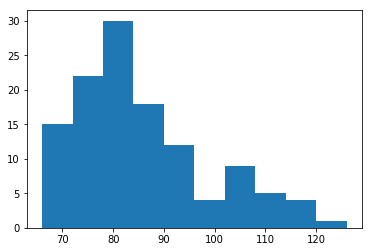

In [11]:
plt.hist(labels_df.pivot_table(index='breed', aggfunc=len).values);

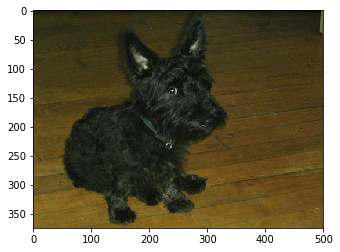

In [12]:
img = plt.imread(PATH + 'train/' + labels_df.sample(1)['id'].values[0] + '.jpg')
plt.imshow(img)

### Sample subset of images (for cpu only)

In [13]:
frac = 0.5
sample_labels_df = labels_df.sample(frac=frac).set_index('id')
sample_labels_df.to_csv(PATH + 'sample_labels.csv')

In [14]:
print('Sample:', len(sample_labels_df), ' out of', len(labels_df), 'observations.')
sample_labels_df.head()

Sample: 5111  out of 10222 observations.


,breed
id,
a9607591357d1f93bfbab4cabbe73c7c,leonberg
e7bc17ef352ef576b73467ebe9a407f1,airedale
8eed4ce43508497ca2fb97b5052c719b,australian_terrier
fefb453e43ec5e840c323538261493bd,lhasa
5b903adeb4c923ba3046929c7062927a,beagle


# Model

> If the original images do not correspond to this size, thei are center cropped. For computational GPU reasons, the cropped images must be squared."

In [15]:
# Image size to feed into the model.  
sz = 224

arch = resnext101_64  # resnet34  # Model architecture.
bs = 64  # Batch size


n = len(sample_labels_df)  # len(list(open(PATH + 'labels.csv'))) - 1
val_idxs = get_cv_idxs(n, val_pct=0.2)

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'sample_labels.csv',
                                    test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [17]:
fn = PATH + data.trn_ds.fnames[100]; fn

'../data/dog-breed-identification/train/068314c65cbe67fa4f57283f4f3a801c.jpg'

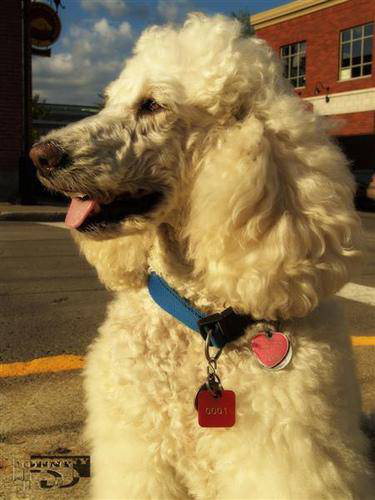

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(375, 500)

In [20]:
sizes_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*sizes_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

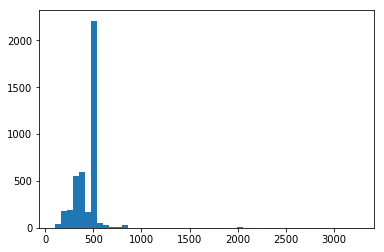

In [21]:
plt.hist(row_sz, bins = 50);  # semi-colon for not printing the bins of the histogram.

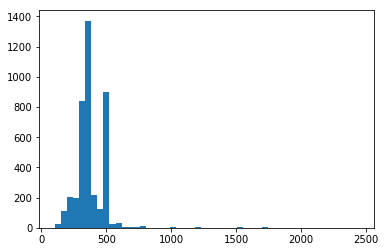

In [22]:
plt.hist(col_sz, bins = 50);

## 1. Precompute

* `precomute = True` ensures that the activations of all the frozen layers in the model are computed only once.  Afterwards, they serve as input to the last (unfrozen) layers of the model for gradient descent, speeding up computation. 
* `precompute = False` enables the recalculation of the frozen layers' activations and, thus, allows data augmentation.  However, only the weights from the unfrozen layers are being updated.
* `learn.unfreeze()` unfreezes all the layers of the model for further calibration.

The following function helps iterate faster with the model.  It receives the image's size (`sz`) and the batch size (`bs`).

1. Start with small sizes (eg. 64) for fast computing at the beginning.  Then increase the size.
1. If one runs out of memory, first **restart the kernel**, then decrease the batch size.


In [23]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'sample_labels.csv',
                                        test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [24]:
sz = 224
bs = 64
data = get_data(sz, bs)

In [25]:
# See http://forums.fast.ai/t/dog-breed-challenge-precompute-error/10988/8
# If No such file... error: ~/data/dog-breed-identification$ rm -r tmp
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [05:47<00:00,  2.15s/it]


In [26]:
# learn.save('pretrained_128')
learn.save('pretrained_224')

In [27]:
# learn.load('pretrained_128')
learn.load('pretrained_224')

 78%|███████▊  | 50/64 [00:01<00:00, 37.56it/s, loss=0.817]


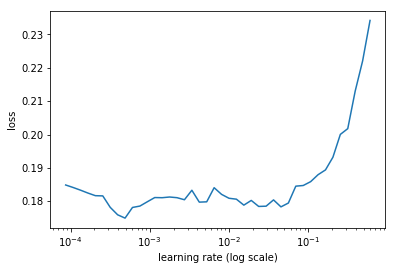

In [29]:
lrf = learn.lr_find()
# learn.sched.plot_lr()
learn.sched.plot()

In [28]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      2.047721   0.703083   0.874755  
    1      0.924582   0.439781   0.913894                  
    2      0.528135   0.390155   0.902153                  
    3      0.36706    0.345212   0.909002                  
    4      0.268235   0.328885   0.910959                  



[array([0.32889]), 0.9109589042262322]

> The difference between `trn_loss` and `val_loss` indicates **overfitting**.  Maybe with dropout (`ps` parameter in `ConvLearner.pretrained`) or another form of regularization.

In [30]:
# ps: dropout parameter
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.75)

In [32]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                  
    0      0.812707   0.374375   0.908023  
    1      0.753955   0.34623    0.907045                  
    2      0.700556   0.332985   0.907045                  
    3      0.63021    0.320979   0.90998                   
    4      0.595893   0.304265   0.908023                  



[array([0.30427]), 0.9080234834825922]

## 2. Augment 

In [33]:
from sklearn import metrics

In [34]:
data = get_data(sz, bs)

In [35]:
learn.precompute = False

In [36]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.664956   0.29441    0.914873  
    1      0.645733   0.295774   0.913894                  



[array([0.29577]), 0.9138943249698721]

In [37]:
learn.save('aug_224')

In [38]:
learn.load('aug_224')

## 3. Increase image size

* This trick needs a _fully convolutional_ architecture.
* It also performs a regularization of sorts, because the data structure changes.

In [39]:
learn.set_data(get_data(299, bs))
learn.freeze()  # Just to make sure its frozen (only updating the weights in the last layers).

 92%|█████████▏| 59/64 [03:56<00:20,  4.00s/it, loss=2.82] 

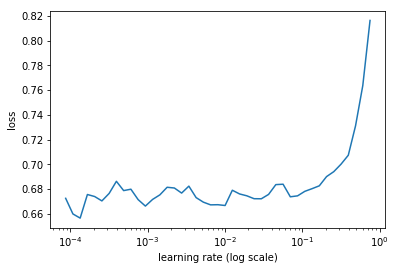

In [40]:
lrf = learn.lr_find()
# learn.sched.plot_lr()
learn.sched.plot()

In [41]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.646035   0.287423   0.919765  
    1      0.669812   0.277733   0.920744                  
    2      0.620064   0.274418   0.920744                  
    3      0.630206   0.270086   0.922701                  
    4      0.591535   0.267946   0.920744                  
    5      0.565349   0.264047   0.921722                  
    6      0.546847   0.263988   0.923679                  


[array([0.26399]), 0.92367905984886]

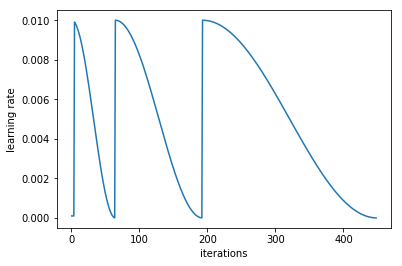

In [42]:
learn.sched.plot_lr()

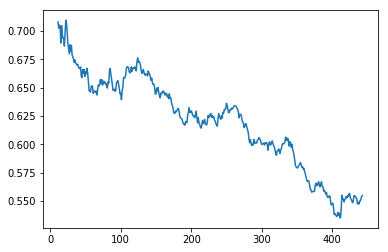

In [43]:
learn.sched.plot_loss()

In [44]:
learn.save('model_299')